# **Uploading and extracting the dataset**

In [ ]:
from google.colab import files
upload = files.upload()

Saving dataset_all_ethnicity.zip to dataset_all_ethnicity.zip


In [ ]:
import zipfile
import os

# Specify the name of the uploaded zip file
zip_file_name = "dataset_all_ethnicity.zip"

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall("dataset")

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as L
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from sklearn.model_selection import train_test_split

In [ ]:
import matplotlib.pyplot as plt
import random
from PIL import Image

# **Visualizing the 10 random pictures**

In [ ]:
def load_img(img_path, target_size):
    img = Image.open(img_path)
    img = img.resize(target_size)
    return img

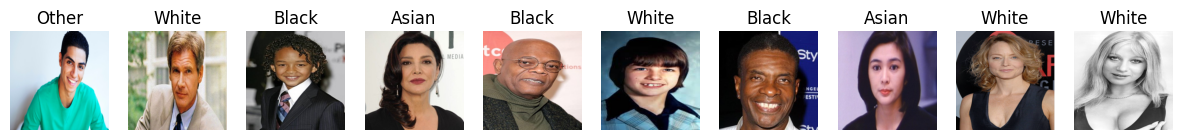

In [ ]:
def is_valid_image_file(filename):
    valid_extensions = {".jpg", ".jpeg", ".png", ".bmp", ".gif"}
    return filename.lower().endswith(tuple(valid_extensions))

def get_random_image_from_subdirectory(directory):
    subdirectories = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    while True:
        selected_subdir = random.choice(subdirectories)
        selected_subdir_path = os.path.join(directory, selected_subdir)
        image_files = [f for f in os.listdir(selected_subdir_path) if is_valid_image_file(f)]
        if not image_files:
            continue
        random_image_file = random.choice(image_files)
        return os.path.join(selected_subdir_path, random_image_file)

# Adjust this path
main_dataset_directory = os.path.join("dataset", "dataset_all_ethnicity")

# Displaying 5 random
plt.figure(figsize=(15, 10))
for i in range(10):
    img_path = get_random_image_from_subdirectory(main_dataset_directory)
    img = load_img(img_path, target_size=(224, 224))
    plt.subplot(1, 10, i+1)
    plt.imshow(img)
    plt.title(os.path.basename(os.path.dirname(img_path)))
    plt.axis('off')
plt.show()

# **Removing corrupted images**

In [ ]:
## removing corrupted images , because in previous code i realize that there are images which are corrupted

In [ ]:
import os
import cv2

# Define the directory containing your dataset
dataset_dir = "/content/dataset/dataset_all_ethnicity"

# Function to check if an image file is corrupted
def is_corrupted_image(image_path):
    try:
        img = cv2.imread(image_path)
        if img is None:
            return True
        else:
            return False
    except:
        return True

# List to store the names of corrupted images
corrupted_images = []

# Iterate through the dataset directory and subdirectories
for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        # Check if the file is an image
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            # Construct the full path to the image file
            image_path = os.path.join(root, file)
            # Check if the image is corrupted
            if is_corrupted_image(image_path):
                corrupted_images.append(image_path)
                # Remove the corrupted image file
                os.remove(image_path)

# Print the names of corrupted images
print("Corrupted images:")
for image_path in corrupted_images:
    print(image_path)

Corrupted images:


# **Splitting the dataset**

In [ ]:
!pip install split-folders

In [ ]:
import splitfolders

# The dataset directory
input_folder = '/content/dataset/dataset_all_ethnicity'
# splitted dataset directory
output = 'splitted_dataset'

# Split with a ratio of 70-15-15
splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.7, .15, .15))

Copying files: 300 files [00:00, 2167.21 files/s]


# **Removing irrelevent folders**

In [ ]:
## remove specific folders like "_MACOSX" and "dataset_all_ethnicity" from the train, validation, and test folders

In [ ]:
import os

# Define the paths to train, validation, and test folders
train_path = '/content/splitted_dataset/train'
validation_path = '/content/splitted_dataset/val'
test_path = '/content/splitted_dataset/test'

# List all the folders in each directory
train_folders = os.listdir(train_path)
validation_folders = os.listdir(validation_path)
test_folders = os.listdir(test_path)

# Remove the unwanted folders
unwanted_folders = ['__MACOSX', 'dataset_all_ethnicity']

for folder in unwanted_folders:
    if folder in train_folders:
        os.rmdir(os.path.join(train_path, folder))
    if folder in validation_folders:
        os.rmdir(os.path.join(validation_path, folder))
    if folder in test_folders:
        os.rmdir(os.path.join(test_path, folder))

# **Deploying CNN models**

# **VGG16**

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, VGG19, MobileNetV2, DenseNet169, InceptionV3, ResNet50
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [ ]:
# Define paths to the dataset directories
train_dir = '/content/splitted_dataset/train'
validation_dir = '/content/splitted_dataset/val'
test_dir = '/content/splitted_dataset/test'


num_classes = 5

# Define image dimensions
img_height, img_width = 224, 224
batch_size = 32

# Create data generators without data augmentation
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 210 images belonging to 5 classes.
Found 45 images belonging to 5 classes.


In [ ]:
# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of the pre-trained model
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation='softmax'))  # Assuming 5 classes for ethnicities

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:


# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

# Evaluate the model
test_generator = validation_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)

Epoch 1/20
6/6 [==============================] - 130s 22s/step - loss: 17.7624 - accuracy: 0.2584 - val_loss: 11.4837 - val_accuracy: 0.2188
Epoch 2/20
6/6 [==============================] - 127s 23s/step - loss: 5.8893 - accuracy: 0.2978 - val_loss: 2.4038 - val_accuracy: 0.2188
Epoch 3/20
6/6 [==============================] - 130s 22s/step - loss: 3.0095 - accuracy: 0.3596 - val_loss: 3.2027 - val_accuracy: 0.2188
Epoch 4/20
6/6 [==============================] - 127s 22s/step - loss: 2.2606 - accuracy: 0.4101 - val_loss: 2.5654 - val_accuracy: 0.1562
Epoch 5/20
6/6 [==============================] - 128s 22s/step - loss: 1.1811 - accuracy: 0.5899 - val_loss: 1.6903 - val_accuracy: 0.2500
Epoch 6/20
6/6 [==============================] - 128s 21s/step - loss: 1.6369 - accuracy: 0.5562 - val_loss: 2.5043 - val_accuracy: 0.1875
Epoch 7/20
6/6 [==============================] - 148s 25s/step - loss: 1.1095 - accuracy: 0.5562 - val_loss: 2.0049 - val_accuracy: 0.2812
Epoch 8/20
6/6 [==

In [ ]:
## VGG16 with 10 Epoches has the accuracy of 32 with the same loss

# **VGG19**

In [ ]:
from tensorflow.keras.applications import VGG19

In [ ]:
# Load the pre-trained VGG19 model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of the pre-trained model
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation='softmax'))  # 5 classes for ethnicities

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size)

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Evaluate the model
test_generator = validation_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)
# Get the evaluation metrics
evaluation = model.evaluate(test_generator)
print("Test Accuracy:", evaluation[1])
print("Test Loss:", evaluation[0])

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size)

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Evaluate the model
test_generator = validation_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

# Get the evaluation metrics
evaluation = model.evaluate(test_generator)
print("Test Accuracy:", evaluation[1])
print("Test Loss:", evaluation[0])

Epoch 1/20
6/6 [==============================] - 160s 27s/step - loss: 2.2596 - accuracy: 0.1910 - val_loss: 1.8907 - val_accuracy: 0.1875
Epoch 2/20
6/6 [==============================] - 186s 32s/step - loss: 1.7485 - accuracy: 0.2917 - val_loss: 1.7040 - val_accuracy: 0.2500
Epoch 3/20
6/6 [==============================] - 174s 30s/step - loss: 1.3541 - accuracy: 0.4438 - val_loss: 1.5448 - val_accuracy: 0.3125
Epoch 4/20
6/6 [==============================] - 157s 27s/step - loss: 1.1428 - accuracy: 0.5169 - val_loss: 1.6448 - val_accuracy: 0.1562
Epoch 5/20
6/6 [==============================] - 175s 30s/step - loss: 0.9684 - accuracy: 0.6573 - val_loss: 1.5295 - val_accuracy: 0.3125
Epoch 6/20
6/6 [==============================] - 157s 27s/step - loss: 0.8165 - accuracy: 0.7584 - val_loss: 1.4590 - val_accuracy: 0.3750
Epoch 7/20
6/6 [==============================] - 176s 30s/step - loss: 0.6103 - accuracy: 0.8202 - val_loss: 1.4393 - val_accuracy: 0.4062
Epoch 8/20
6/6 [====

# **MobileNet V2**

In [ ]:
## chun in chizaei ke paein tarif shode tu pre train e ghabli tarif karde budim,
## alan dge niaz be ejraye dobareye in tike nist

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define data directories
train_dir = '/content/splitted_dataset/train'
validation_dir = '/content/splitted_dataset/val'

num_classes = 5

# Define image dimensions
img_height, img_width = 224, 224
batch_size = 32

# Create data generators without data augmentation
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 210 images belonging to 5 classes.
Found 45 images belonging to 5 classes.


In [ ]:
# Load MobileNetV2 model without the top classification layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add custom classification head on top of the base model
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=10
)

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/10
6/6 [==============================] - 99s 19s/step - loss: 1.8815 - accuracy: 0.1771 - val_loss: 1.7076 - val_accuracy: 0.1250
Epoch 2/10
6/6 [==============================] - 13s 2s/step - loss: 1.1674 - accuracy: 0.5521 - val_loss: 1.6186 - val_accuracy: 0.2812
Epoch 3/10
6/6 [==============================] - 11s 2s/step - loss: 0.7931 - accuracy: 0.7865 - val_loss: 1.6932 - val_accuracy: 0.4062
Epoch 4/10
6/6 [==============================] - 11s 2s/step - loss: 0.5649 - accuracy: 0.8820 - val_loss: 1.5438 - val_accuracy: 0.4375
Epoch 5/10
6/6 [==============================] - 14s 2s/step - loss: 0.4275 - accuracy: 0.9479 - val_loss: 1.5300 - val_accuracy: 0.4062
Epoch 6/10
6/6 [==============================] - 11s 2s/step - loss: 0.3147 - accuracy: 0.9607 - val_loss: 1.8166 - val_accuracy: 0.3125
Epoch 7/10
6/6 [==============================] - 11s 2s/step - loss: 0.2264 - accuracy: 0.9831 - val_loss: 

# **DenseNet 169**

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [ ]:
from keras.applications import DenseNet169
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D

# Define paths to the dataset directories
train_dir = '/content/splitted_dataset/train'
validation_dir = '/content/splitted_dataset/val'
test_dir = '/content/splitted_dataset/test'

num_classes = 5
img_height, img_width = 224, 224
batch_size = 32

# Load the pre-trained DenseNet169 model
base_model = DenseNet169(weights='imagenet', include_top=False)

# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully-connected layer
x = Dense(1024, activation='relu')(x)

# Add a logistic layer with softmax activation for classification
predictions = Dense(num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Data generators without data augmentation
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Train the model
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=10
)

# Evaluate the model on the test set
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Get the evaluation metrics
evaluation = model.evaluate(test_generator)
print("Test Accuracy:", evaluation[1])
print("Test Loss:", evaluation[0])

Found 210 images belonging to 5 classes.
Found 45 images belonging to 5 classes.
Epoch 1/10
6/6 [==============================] - 65s 8s/step - loss: 3.0669 - accuracy: 0.1910 - val_loss: 2.5732 - val_accuracy: 0.1562
Epoch 2/10
6/6 [==============================] - 43s 7s/step - loss: 1.8999 - accuracy: 0.4045 - val_loss: 1.9022 - val_accuracy: 0.3438
Epoch 3/10
6/6 [==============================] - 48s 8s/step - loss: 1.3128 - accuracy: 0.4775 - val_loss: 1.7124 - val_accuracy: 0.1875
Epoch 4/10
6/6 [==============================] - 47s 8s/step - loss: 0.9884 - accuracy: 0.5955 - val_loss: 1.7212 - val_accuracy: 0.2500
Epoch 5/10
6/6 [==============================] - 41s 7s/step - loss: 0.8152 - accuracy: 0.7584 - val_loss: 1.6219 - val_accuracy: 0.4062
Epoch 6/10
6/6 [==============================] - 44s 8s/step - loss: 0.6707 - accuracy: 0.8177 - val_loss: 1.6763 - val_accuracy: 0.3125
Epoch 7/10
6/6 [==============================] - 45s 8s/step - loss: 0.5403 - accuracy: 0.

In [ ]:
## train the previous model with epochs = 20 but the result not improved

In [ ]:
# Train the model
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=20
)

# Evaluate the model on the test set
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Get the evaluation metrics
evaluation = model.evaluate(test_generator)
print("Test Accuracy:", evaluation[1])
print("Test Loss:", evaluation[0])

Epoch 1/20
6/6 [==============================] - 44s 7s/step - loss: 0.2399 - accuracy: 0.9775 - val_loss: 1.5235 - val_accuracy: 0.4375
Epoch 2/20
6/6 [==============================] - 43s 7s/step - loss: 0.1840 - accuracy: 0.9888 - val_loss: 1.7060 - val_accuracy: 0.3438
Epoch 3/20
6/6 [==============================] - 49s 8s/step - loss: 0.1457 - accuracy: 1.0000 - val_loss: 1.8044 - val_accuracy: 0.3750
Epoch 4/20
6/6 [==============================] - 48s 9s/step - loss: 0.1125 - accuracy: 1.0000 - val_loss: 1.6438 - val_accuracy: 0.3750
Epoch 5/20
6/6 [==============================] - 46s 8s/step - loss: 0.0877 - accuracy: 1.0000 - val_loss: 1.6540 - val_accuracy: 0.4375
Epoch 6/20
6/6 [==============================] - 47s 8s/step - loss: 0.0772 - accuracy: 1.0000 - val_loss: 1.8804 - val_accuracy: 0.3750
Epoch 7/20
6/6 [==============================] - 46s 8s/step - loss: 0.0667 - accuracy: 1.0000 - val_loss: 1.8176 - val_accuracy: 0.4062
Epoch 8/20
6/6 [==================

In [ ]:
## adding two more layer : Dense layers (512 units and 256 units) after the initial Dense layer with 1024 units.
# but the accuracy decreased

In [ ]:
from keras.applications import DenseNet169
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Define paths to the dataset directories
train_dir = '/content/splitted_dataset/train'
validation_dir = '/content/splitted_dataset/val'
test_dir = '/content/splitted_dataset/test'

num_classes = 5
img_height, img_width = 224, 224
batch_size = 32

# Load the pre-trained DenseNet169 model
base_model = DenseNet169(weights='imagenet', include_top=False)

# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully-connected layer
x = Dense(1024, activation='relu')(x)

# Add another fully-connected layer
x = Dense(512, activation='relu')(x)

# Add another fully-connected layer
x = Dense(256, activation='relu')(x)

# Add a logistic layer with softmax activation for classification
predictions = Dense(num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Data generators without data augmentation
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Train the model
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=10
)

# Evaluate the model on the test set
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Get the evaluation metrics
evaluation = model.evaluate(test_generator)
print("Test Accuracy:", evaluation[1])
print("Test Loss:", evaluation[0])

Found 210 images belonging to 5 classes.
Found 45 images belonging to 5 classes.
Epoch 1/10
6/6 [==============================] - 58s 8s/step - loss: 2.3883 - accuracy: 0.2079 - val_loss: 1.7762 - val_accuracy: 0.2188
Epoch 2/10
6/6 [==============================] - 42s 7s/step - loss: 1.6244 - accuracy: 0.2640 - val_loss: 1.6416 - val_accuracy: 0.3125
Epoch 3/10
6/6 [==============================] - 42s 7s/step - loss: 1.4845 - accuracy: 0.4045 - val_loss: 1.7335 - val_accuracy: 0.1875
Epoch 4/10
6/6 [==============================] - 39s 7s/step - loss: 1.3644 - accuracy: 0.4213 - val_loss: 1.6964 - val_accuracy: 0.3438
Epoch 5/10
6/6 [==============================] - 42s 7s/step - loss: 1.1159 - accuracy: 0.6011 - val_loss: 1.7536 - val_accuracy: 0.2500
Epoch 6/10
6/6 [==============================] - 43s 7s/step - loss: 0.9658 - accuracy: 0.6292 - val_loss: 1.6850 - val_accuracy: 0.3750
Epoch 7/10
6/6 [==============================] - 39s 6s/step - loss: 0.7219 - accuracy: 0.

In [ ]:
# now, instead of x = Dense(256, activation='relu')(x)
# i want to use x = Dense(256, activation='sigmoid')(x)
# but the accuracy decreased again

In [ ]:
from keras.applications import DenseNet169
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Define paths to the dataset directories
train_dir = '/content/splitted_dataset/train'
validation_dir = '/content/splitted_dataset/val'
test_dir = '/content/splitted_dataset/test'

num_classes = 5
img_height, img_width = 224, 224
batch_size = 32

# Load the pre-trained DenseNet169 model
base_model = DenseNet169(weights='imagenet', include_top=False)

# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully-connected layer
x = Dense(1024, activation='relu')(x)

# Add another fully-connected layer
x = Dense(512, activation='relu')(x)


# Add another fully-connected layer with 256 units and 'sigmoid' activation
x = Dense(256, activation='sigmoid')(x)

# Add a logistic layer with softmax activation for classification
predictions = Dense(num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Data generators without data augmentation
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Train the model
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=10
)

# Evaluate the model on the test set
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Get the evaluation metrics
evaluation = model.evaluate(test_generator)
print("Test Accuracy:", evaluation[1])
print("Test Loss:", evaluation[0])

Found 210 images belonging to 5 classes.
Found 45 images belonging to 5 classes.
Epoch 1/10
6/6 [==============================] - 61s 9s/step - loss: 1.8511 - accuracy: 0.1517 - val_loss: 1.6704 - val_accuracy: 0.2812
Epoch 2/10
6/6 [==============================] - 43s 7s/step - loss: 1.6336 - accuracy: 0.2809 - val_loss: 1.6348 - val_accuracy: 0.2188
Epoch 3/10
6/6 [==============================] - 41s 7s/step - loss: 1.4908 - accuracy: 0.3371 - val_loss: 1.6129 - val_accuracy: 0.3750
Epoch 4/10
6/6 [==============================] - 39s 7s/step - loss: 1.3773 - accuracy: 0.4888 - val_loss: 1.6832 - val_accuracy: 0.2500
Epoch 5/10
6/6 [==============================] - 44s 7s/step - loss: 1.2465 - accuracy: 0.5393 - val_loss: 1.4350 - val_accuracy: 0.4375
Epoch 6/10
6/6 [==============================] - 38s 7s/step - loss: 0.9161 - accuracy: 0.7135 - val_loss: 1.5677 - val_accuracy: 0.3438
Epoch 7/10
6/6 [==============================] - 42s 7s/step - loss: 0.7193 - accuracy: 0.

# **InceptionV3**

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load pre-trained InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add custom layers on top of the base model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=10
)

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

87910968/87910968 [==============================] - 0s 0us/step
Epoch 1/10
6/6 [==============================] - 129s 17s/step - loss: 2.3918 - accuracy: 0.2640 - val_loss: 12.2570 - val_accuracy: 0.2188
Epoch 2/10
6/6 [==============================] - 89s 15s/step - loss: 1.6075 - accuracy: 0.3315 - val_loss: 88.0648 - val_accuracy: 0.1875
Epoch 3/10
6/6 [==============================] - 91s 15s/step - loss: 1.4354 - accuracy: 0.4326 - val_loss: 23.0348 - val_accuracy: 0.2188
Epoch 4/10
6/6 [==============================] - 97s 16s/step - loss: 1.1182 - accuracy: 0.5729 - val_loss: 3.1812 - val_accuracy: 0.2500
Epoch 5/10
6/6 [==============================] - 90s 15s/step - loss: 0.9227 - accuracy: 0.6910 - val_loss: 1.8023 - val_accuracy: 0.2500
Epoch 6/10
6/6 [==============================] - 95s 16s/step - loss: 0.5863 - accuracy: 0.8385 - val_loss: 1.7389 - val_accuracy: 0.2188
Epoch 7/10
6/6 [==============================] - 88s 15s/step - loss: 0.3764 - accuracy: 0.8652 

# **ResNet 50**

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add custom layers on top of the base model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=10
)

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

94765736/94765736 [==============================] - 1s 0us/step
Epoch 1/10
6/6 [==============================] - 167s 24s/step - loss: 3.1517 - accuracy: 0.2022 - val_loss: 4.5914 - val_accuracy: 0.1250
Epoch 2/10
6/6 [==============================] - 142s 24s/step - loss: 1.2832 - accuracy: 0.5674 - val_loss: 3.7392 - val_accuracy: 0.2188
Epoch 3/10
6/6 [==============================] - 149s 25s/step - loss: 0.7599 - accuracy: 0.7584 - val_loss: 4.8064 - val_accuracy: 0.2812
Epoch 4/10
6/6 [==============================] - 154s 26s/step - loss: 0.4206 - accuracy: 0.8764 - val_loss: 42.2517 - val_accuracy: 0.1562
Epoch 5/10
6/6 [==============================] - 145s 24s/step - loss: 0.3209 - accuracy: 0.9270 - val_loss: 15.1604 - val_accuracy: 0.0938
Epoch 6/10
6/6 [==============================] - 137s 23s/step - loss: 0.2694 - accuracy: 0.8989 - val_loss: 4.2660 - val_accuracy: 0.2188
Epoch 7/10
6/6 [==============================] - 142s 24s/step - loss: 0.2242 - accuracy: 0.

In [ ]:
!pip install keras-vggface

In [ ]:
pip show keras-vggface

In [ ]:
from keras_vggface.vggface import VGGFace

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
#from keras_applications import VGGFace


# Load pre-trained VGG-Face model
base_model = VGGFace(model='vgg16', include_top=False, input_shape=(img_height, img_width, 3))

# Add custom layers on top of the base model
#model = Sequential([
 #   base_model,
 #   GlobalAveragePooling2D(),
 #   Dense(512, activation='relu'),
 #   Dense(num_classes, activation='softmax')
#])

######### az paein ezafe shodan##########
# Customize the top layers
x = Flatten()(base_model.output)
x = Dense(4096, activation='relu')(x)
x = Dense(4096, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# create the model
model = Model(inputs=base_model.input, outputs=predictions)
#####################################

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=10
)

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

ModuleNotFoundError: No module named 'keras_applications'

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from keras.applications.vgg16 import VGG16

def VGG_Face(input_shape=(224, 224, 3), num_classes=5):
    # Load pre-trained VGG16 model trained on VGG-Face dataset
    base_model = VGG16(weights='vggface', include_top=False, input_shape=input_shape)

    # Customize the top layers
    x = Flatten()(base_model.output)
    x = Dense(4096, activation='relu')(x)
    x = Dense(4096, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = Model(inputs=base_model.input, outputs=predictions)

    return model

# Create VGG-Face model
vgg_face_model = VGG_Face()

# Print model summary
vgg_face_model.summary()

# **Creating data generators with data augmentation for training and validation**

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import tensorflow as tf
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [ ]:
train_dir = '/content/splitted_dataset/train'
validation_dir = '/content/splitted_dataset/val'
test_dir = '/content/splitted_dataset/test'

num_classes = 5

# Define image dimensions
img_height, img_width = 224, 224
batch_size = 32

# Create data generators with data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Load MobileNetV2 model without the top classification layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add custom classification head on top of the base model
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=10
)

# Evaluate the model on the test set
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Get the evaluation metrics
evaluation = model.evaluate(test_generator)
print("Test Accuracy:", evaluation[1])
print("Test Loss:", evaluation[0])

Found 210 images belonging to 5 classes.
Found 45 images belonging to 5 classes.
Epoch 1/10
6/6 [==============================] - 30s 5s/step - loss: 2.0356 - accuracy: 0.2083 - val_loss: 2.1625 - val_accuracy: 0.2188
Epoch 2/10
6/6 [==============================] - 15s 2s/step - loss: 1.6347 - accuracy: 0.3146 - val_loss: 1.6642 - val_accuracy: 0.3438
Epoch 3/10
6/6 [==============================] - 14s 2s/step - loss: 1.2839 - accuracy: 0.5000 - val_loss: 1.5779 - val_accuracy: 0.3438
Epoch 4/10
6/6 [==============================] - 15s 2s/step - loss: 1.1917 - accuracy: 0.5112 - val_loss: 1.6016 - val_accuracy: 0.2500
Epoch 5/10
6/6 [==============================] - 14s 2s/step - loss: 1.0063 - accuracy: 0.6573 - val_loss: 1.7770 - val_accuracy: 0.2500
Epoch 6/10
6/6 [==============================] - 14s 2s/step - loss: 0.9584 - accuracy: 0.6854 - val_loss: 1.6433 - val_accuracy: 0.3750
Epoch 7/10
6/6 [==============================] - 15s 2s/step - loss: 0.8560 - accuracy: 0.

In [ ]:
## VGG 16

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.optimizers import Adam


# Define paths to the dataset directories
train_dir = '/content/splitted_dataset/train'
validation_dir = '/content/splitted_dataset/val'
test_dir = '/content/splitted_dataset/test'


num_classes = 5

# Define image dimensions
img_height, img_width = 224, 224
batch_size = 32

# Create data generators without data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)



# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of the pre-trained model
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation='softmax'))  # Assuming 5 classes for ethnicities

# Compile the model

#model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
             # loss='categorical_crossentropy',
             # metrics=['accuracy'])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

# Evaluate the model on the test set
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Get the evaluation metrics
evaluation = model.evaluate(test_generator)
print("Test Accuracy:", evaluation[1])
print("Test Loss:", evaluation[0])

Found 210 images belonging to 5 classes.
Found 45 images belonging to 5 classes.
58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/20
6/6 [==============================] - 131s 22s/step - loss: 2.2416 - accuracy: 0.2079 - val_loss: 1.9009 - val_accuracy: 0.1250
Epoch 2/20
6/6 [==============================] - 139s 23s/step - loss: 1.7584 - accuracy: 0.2760 - val_loss: 1.6732 - val_accuracy: 0.2500
Epoch 3/20
6/6 [==============================] - 136s 23s/step - loss: 1.7725 - accuracy: 0.2191 - val_loss: 1.6698 - val_accuracy: 0.2188
Epoch 4/20
6/6 [==============================] - 139s 24s/step - loss: 1.6825 - accuracy: 0.2708 - val_loss: 1.7806 - val_accuracy: 0.2500
Epoch 5/20
6/6 [==============================] - 129s 23s/step - loss: 1.6467 - accuracy: 0.3146 - val_loss: 1.6578 - val_accuracy: 0.1875
Epoch 6/20
6/6 [==============================] - 130s 22s/step - loss: 1.4832 - accuracy: 0.3315 - val_loss: 1.7058 - val_accuracy: 0.1562
Epoch 7/20
6/6

In [ ]:
## DenseNet169

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [ ]:
from keras.applications import DenseNet169
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D

# Define paths to the dataset directories
train_dir = '/content/splitted_dataset/train'
validation_dir = '/content/splitted_dataset/val'
test_dir = '/content/splitted_dataset/test'

num_classes = 5
img_height, img_width = 224, 224
batch_size = 32

# Load the pre-trained DenseNet169 model
base_model = DenseNet169(weights='imagenet', include_top=False)

# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully-connected layer
x = Dense(1024, activation='relu')(x)

# Add a logistic layer with softmax activation for classification
predictions = Dense(num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Data generators with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Train the model
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=10
)

# Evaluate the model on the test set
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Get the evaluation metrics
evaluation = model.evaluate(test_generator)
print("Test Accuracy:", evaluation[1])
print("Test Loss:", evaluation[0])

51877672/51877672 [==============================] - 0s 0us/step
Found 210 images belonging to 5 classes.
Found 45 images belonging to 5 classes.
Epoch 1/10
6/6 [==============================] - 63s 9s/step - loss: 2.5878 - accuracy: 0.1854 - val_loss: 2.0108 - val_accuracy: 0.1875
Epoch 2/10
6/6 [==============================] - 50s 8s/step - loss: 1.6952 - accuracy: 0.3315 - val_loss: 2.1187 - val_accuracy: 0.1250
Epoch 3/10
6/6 [==============================] - 47s 8s/step - loss: 1.4337 - accuracy: 0.3708 - val_loss: 1.6703 - val_accuracy: 0.3750
Epoch 4/10
6/6 [==============================] - 55s 9s/step - loss: 1.2170 - accuracy: 0.5337 - val_loss: 1.7011 - val_accuracy: 0.2188
Epoch 5/10
6/6 [==============================] - 47s 8s/step - loss: 1.1089 - accuracy: 0.5281 - val_loss: 1.6791 - val_accuracy: 0.3125
Epoch 6/10
6/6 [==============================] - 51s 8s/step - loss: 0.9806 - accuracy: 0.6292 - val_loss: 1.7812 - val_accuracy: 0.2812
Epoch 7/10
6/6 [==========